# Averaging to approximate inner maximization

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,2000)
# seed = 4#62
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

263



# Data preparation

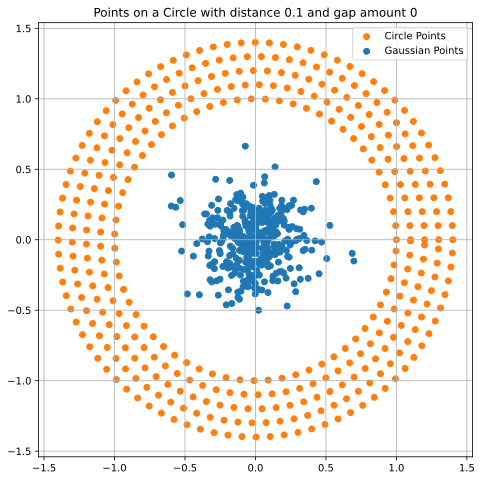

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

def generate_circle_points(radius, eps, gap_amount, dtype=torch.float32, label_type=torch.int64):
    """
    Generates points on a circle of given radius with a minimum distance between points.

    Args:
        radius (float): Radius of the circle.
        eps (float): Minimum Euclidean distance between points.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = []
    angle_step = 2 * np.arcsin(eps / (2 * radius))  # Approximation for minimum angle

    angle = 0.0
    while angle < 2 * np.pi - gap_amount*angle_step:
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        points.append((x, y))
        angle += angle_step

    points = torch.tensor(points, dtype=dtype)
    labels = torch.ones(points.size(0), dtype=label_type)  # Assign label 1 to all points

    return points, labels

def generate_gaussian_points(count, mean, std_dev, dtype=torch.float32, label_type=torch.int64):
    """
    Generates Gaussian-distributed points around a given mean with standard deviation.

    Args:
        count (int): Number of points to generate.
        mean (float): Mean value for Gaussian distribution.
        std_dev (float): Standard deviation for Gaussian distribution.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = torch.normal(mean=mean, std=std_dev, size=(count, 2), dtype=dtype)
    labels = torch.zeros(count, dtype=label_type)  # Assign label 0 to all points

    return points, labels

# Parameters for the circle
radii = [1.,1.1,1.2,1.3,1.4]
epsilon = 0.1
gap_amount = 0

# Generate the dataset for the circle
circle_points_all = torch.zeros(0, dtype=torch.float32)
circle_labels_all = torch.ones(0, dtype=torch.int64)  # Assign label 1 to all points

for radius in radii:
    circle_points, circle_labels = generate_circle_points(radius, epsilon, gap_amount = gap_amount)
    circle_points_all = torch.cat((circle_points_all, circle_points), dim=0)
    circle_labels_all = torch.cat((circle_labels_all, circle_labels), dim=0)        
    

# Generate Gaussian-distributed points
num_gaussian_points = circle_points_all.size(0)
mean = 0.0
std_dev = 0.2
gaussian_points, gaussian_labels = generate_gaussian_points(num_gaussian_points, mean, std_dev)

# Combine datasets
all_points = torch.cat((circle_points_all, gaussian_points), dim=0)
all_labels = torch.cat((circle_labels_all, gaussian_labels), dim=0)



# Plot the points
plt.figure(figsize=(8, 8))
plt.scatter(circle_points_all[:, 0].numpy(), circle_points_all[:, 1].numpy(), color='C1', label='Circle Points')
plt.scatter(gaussian_points[:, 0].numpy(), gaussian_points[:, 1].numpy(), color='C0', label='Gaussian Points')
plt.title(f'Points on a Circle with distance {epsilon} and gap amount {gap_amount}')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True)
plt.show()


In [3]:

plotlim = [-2, 2]
subfolder = 'circ'
# data_size = 800
# aa_amount = 4
# adv_budget = 0.2
batch_size = 20

# Create a DataLoader
dataset = TensorDataset(all_points, all_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



# from models.training import create_dataloader
# dataloader, dataloader_viz = create_dataloader('circles_buffer', factor = factor, plotlim = plotlim, random_state = seed, data_size = data_size)


## Model dynamics

In [4]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE, NeuralODEvar

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, time_steps = 10, 10
num_params = 10
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity =  'tanh' #'tanh'
architecture = 'inside' #outside


## Training and generating level sets

In [5]:
#was 200 for 500 points
num_epochs = 300 #00 #number of optimization runs in which the dataset is used for gradient decent

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODEvar(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=time_steps, num_params= num_params, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


In [6]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, eps = 0, verbose = True) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 0.757
Robust Term Loss: 0.000
Accuracy: 0.600

Iteration 10/38
Loss: 0.710
Robust Term Loss: 0.000
Accuracy: 0.650

Iteration 20/38
Loss: 0.640
Robust Term Loss: 0.000
Accuracy: 0.800

Iteration 30/38
Loss: 0.648
Robust Term Loss: 0.000
Accuracy: 0.800
Epoch 1: 0.690

Iteration 0/38
Loss: 0.671
Robust Term Loss: 0.000
Accuracy: 0.600

Iteration 10/38
Loss: 0.657
Robust Term Loss: 0.000
Accuracy: 0.700

Iteration 20/38
Loss: 0.694
Robust Term Loss: 0.000
Accuracy: 0.550

Iteration 30/38
Loss: 0.677
Robust Term Loss: 0.000
Accuracy: 0.650
Epoch 2: 0.676

Iteration 0/38
Loss: 0.711
Robust Term Loss: 0.000
Accuracy: 0.550

Iteration 10/38
Loss: 0.609
Robust Term Loss: 0.000
Accuracy: 0.800

Iteration 20/38
Loss: 0.645
Robust Term Loss: 0.000
Accuracy: 0.750

Iteration 30/38
Loss: 0.607
Robust Term Loss: 0.000
Accuracy: 0.950
Epoch 3: 0.662

Iteration 0/38
Loss: 0.685
Robust Term Loss: 0.000
Accuracy: 0.700

Iteration 10/38
Loss: 0.635
Robust Term Loss: 0.000
Accuracy:

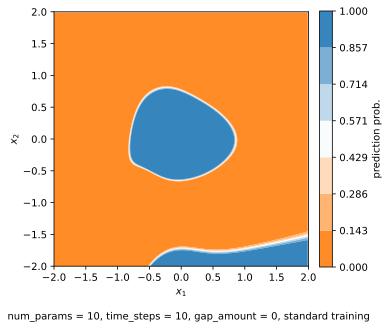

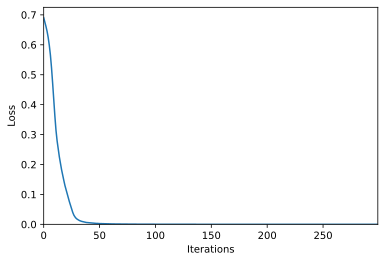

In [7]:
from plots.plots import classification_levelsets
import os
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

footnote = f'{num_params = }, {time_steps = }, {gap_amount = }, standard training'

fig_name_base = os.path.join(subfolder, 'levelsets')
_, ax = classification_levelsets(anode, plotlim = plotlim,
                         footnote=footnote)



plt.savefig(fig_name_base + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')


plt.show()

plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [8]:
for layer in range(num_params):
    weight = anode.flow.dynamics.fc2_time[layer].weight
    rank = torch.matrix_rank(weight)
    # eigenvalues, _ = torch.eig(weight, eigenvectors=False)
    singular_values = torch.svd(weight).S
    
    # print(f'layer {layer} has rank {rank}')
    # print(f'layer {layer} has eigenvalues \n {eigenvalues}')
    print(f'layer {layer} has eigenvalues \n {singular_values}')
    

layer 0 has eigenvalues 
 tensor([0.7771, 0.1603], grad_fn=<SvdBackward>)
layer 1 has eigenvalues 
 tensor([0.8003, 0.0608], grad_fn=<SvdBackward>)
layer 2 has eigenvalues 
 tensor([0.9625, 0.2508], grad_fn=<SvdBackward>)
layer 3 has eigenvalues 
 tensor([0.8344, 0.1973], grad_fn=<SvdBackward>)
layer 4 has eigenvalues 
 tensor([0.8691, 0.2578], grad_fn=<SvdBackward>)
layer 5 has eigenvalues 
 tensor([2.1375, 0.0319], grad_fn=<SvdBackward>)
layer 6 has eigenvalues 
 tensor([0.9179, 0.2538], grad_fn=<SvdBackward>)
layer 7 has eigenvalues 
 tensor([2.1357, 0.2858], grad_fn=<SvdBackward>)
layer 8 has eigenvalues 
 tensor([2.2893, 0.2097], grad_fn=<SvdBackward>)
layer 9 has eigenvalues 
 tensor([3.0056, 0.3513], grad_fn=<SvdBackward>)


In [9]:
def psi_manual(x, model):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^2.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    func = lambda inp: model(inp)[0]
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True)
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1]
    
   
    return singular_values.detach().numpy()

# Define a grid over the input space.
grid_size = 100 # Adjust as needed.
x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)
psi_values = np.zeros((grid_size, grid_size, 2))

# Put the model in evaluation mode.
anode.eval()

# Evaluate psi(x) over the grid.
for i, xv in enumerate(x_range):
    for j, yv in enumerate(y_range):
        # Create a 2D point as a torch tensor.
        x_point = torch.tensor([xv, yv], dtype=torch.float32)
        psi_values[j, i,:] = psi_manual(x_point, anode)

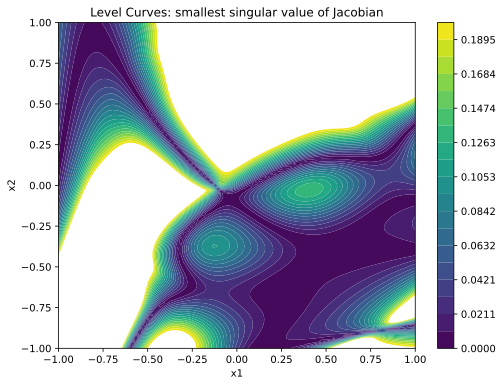

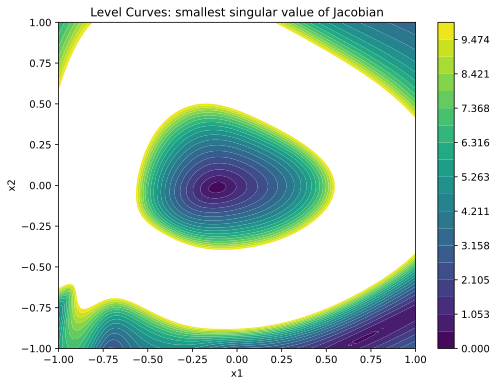

In [10]:

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
# CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

# Define the number of levels for the contour plot
num_levels = 20
levels = np.linspace(0, 0.2, num_levels)
# Create the contour plot using the 'binary' colormap
CS = plt.contourf(x_range, y_range, psi_values[:,:,1], levels=levels, cmap = 'viridis')
cbar = plt.colorbar(CS)
plt.title('Level Curves: smallest singular value of Jacobian')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
# CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

# Define the number of levels for the contour plot
num_levels = 20
levels = np.linspace(0, 10, num_levels)

# Create the contour plot using the 'binary' colormap
CS = plt.contourf(x_range, y_range, psi_values[:,:,0], levels=levels, cmap = 'viridis')
cbar = plt.colorbar(CS)
plt.title('Level Curves: smallest singular value of Jacobian')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()



0
tensor([-0.0962,  0.7990], grad_fn=<SelectBackward>)
1
tensor([1.0353, 0.1365], grad_fn=<SelectBackward>)
2
tensor([0.1902, 0.2497], grad_fn=<SelectBackward>)
3
tensor([-0.9449, -0.5157], grad_fn=<SelectBackward>)
4
tensor([0.2575, 0.4090], grad_fn=<SelectBackward>)
5
tensor([-0.4694,  0.2816], grad_fn=<SelectBackward>)
6
tensor([-0.0476,  0.1130], grad_fn=<SelectBackward>)
7
tensor([-0.2829,  0.2124], grad_fn=<SelectBackward>)
8
tensor([0.0671, 0.2040], grad_fn=<SelectBackward>)
9
tensor([-0.1538, -0.5516], grad_fn=<SelectBackward>)


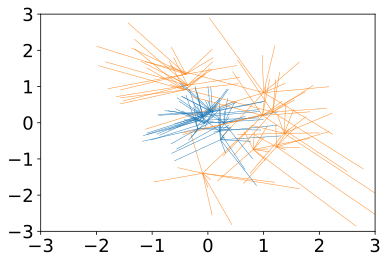

In [18]:
def plot_trajectory(model, inputs, targets, stepsize, time_interval = None, dpi=200, alpha=0.9,
                    alpha_line=0.9, x_lim = [-2,2], y_lim = [-2,2]):
    from matplotlib import rc
    rc("text", usetex=False)
    font = {'size': 18}
    rc('font', **font)

    # Define color based on targets

    color = ['C1' if targets[i] > 0.0 else 'C0' for i in range(len(targets))]
        
    
    
    if time_interval is None:
        time_interval = torch.tensor([0, model.T],dtype=torch.float32)
        
    start_time = time_interval[0].item()
    end_time = time_interval[1].item()
    num_steps_interval = int((end_time - start_time) / stepsize)
    # print('amount steps', num_steps_interval)
    integration_time = torch.arange(start_time, end_time + stepsize/100, stepsize) #using end_time + stepsize gave a weird inconsistency between including and excluding the step_size
    # print(integration_time)
    trajectories = model.flow(inputs, integration_time).detach() #output is of dimension [time_steps, number of inputs, dimension per input]

    
    for i in range(inputs.shape[0]):
        plt.plot(trajectories[:,i, 0], trajectories[:,i, 1], linestyle='-', marker='', color = color[i], alpha = alpha_line, linewidth = 0.5)
        
    
    x_min, x_max = x_lim[0], x_lim[1]
    y_min, y_max = y_lim[0], y_lim[1]
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    
    

    # plt.show()

# Example usage
# model, inputs, targets, timesteps should be defined before calling this function
step_size = T/time_steps 

X_viz, y_viz = next(iter(dataloader))

inputs = torch.tensor([0.,0.])

def Jacobian_subinterval(input, node, time_interval = torch.tensor([0, T], dtype=torch.float32)):
    input_to_output  = lambda input: node.flow(input, time_interval)[-1]
    print(input_to_output(input))
    J = torch.autograd.functional.jacobian(input_to_output, input)
    return J



for i in range(0,10):
    interval = torch.tensor([0,1], dtype=torch.float32) + i
    print(i)
    plot_trajectory(anode, X_viz[0:50], y_viz[0:50],stepsize = step_size, time_interval=interval, x_lim=[-3,3], y_lim = [-3,3])
    Jacobian_subinterval(inputs,anode, time_interval=interval)

In [19]:
time_interval = torch.tensor([0,1], dtype=torch.float32)

def input_to_output(input, node, time_interval = torch.tensor([0, T], dtype=torch.float32)):
    return node.flow(input, time_interval)[-1]

def Jordan(input, node, time_interval = torch.tensor([0, T], dtype=torch.float32)):
    #fix the node so it is just a input to output of the other variable
    input_to_output_lambda = lambda input: input_to_output(input, node, time_interval)
    # Compute the Jacobian matrix
    return torch.autograd.functional.jacobian(input_to_output_lambda, input)
    
    
Jordan(inputs, anode, time_interval = time_interval)

tensor([[ 1.5764,  0.0640],
        [-0.4702,  0.7316]])

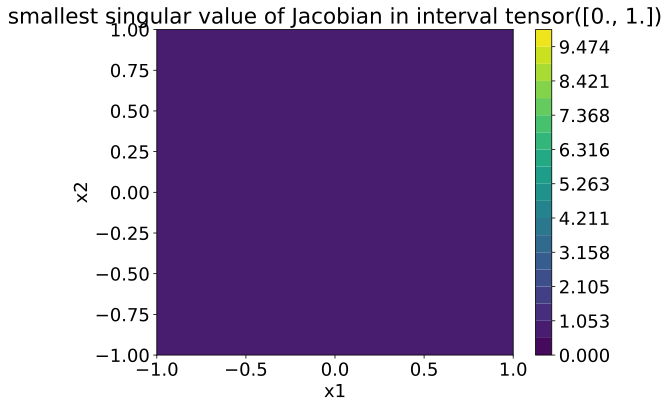

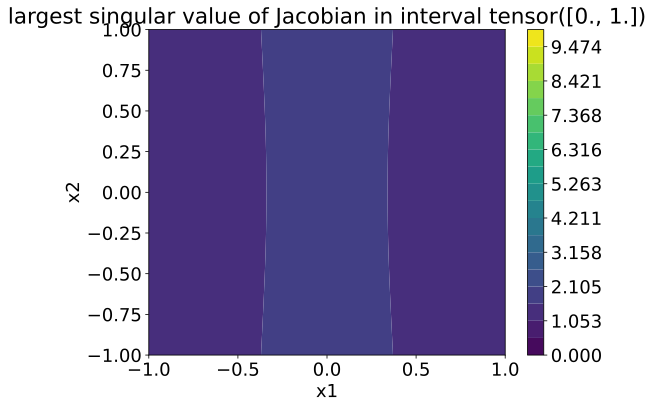

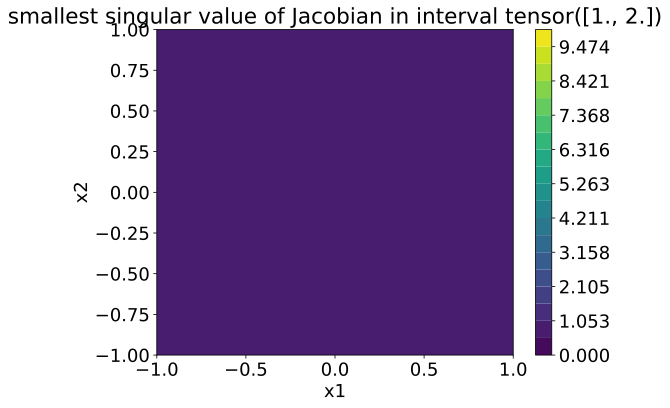

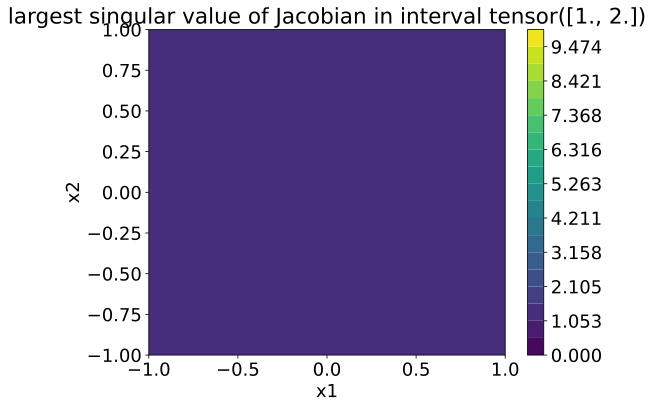

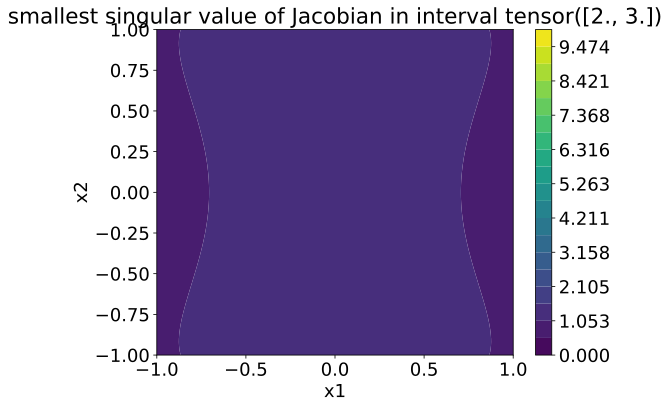

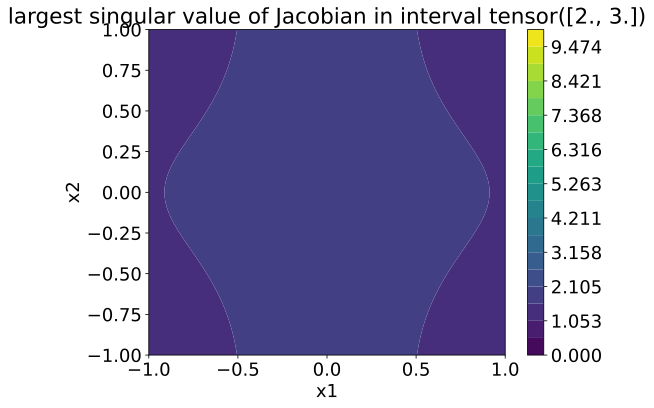

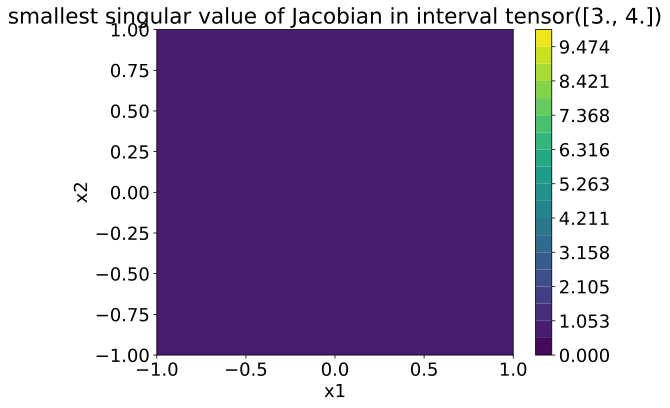

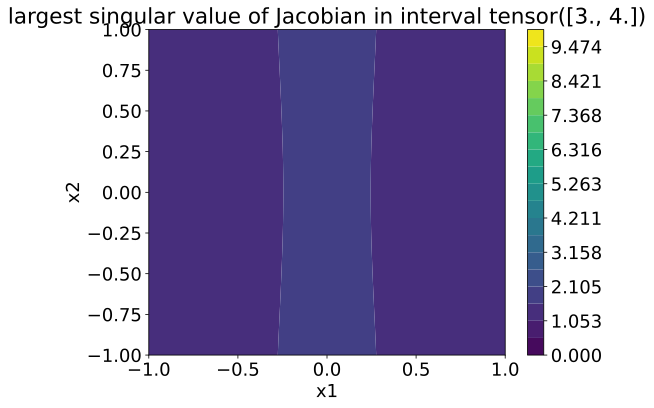

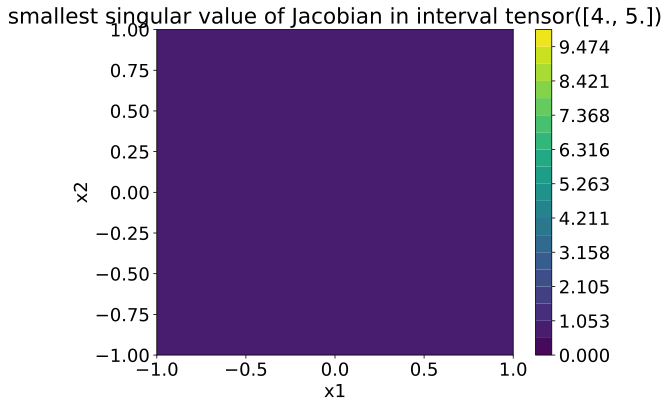

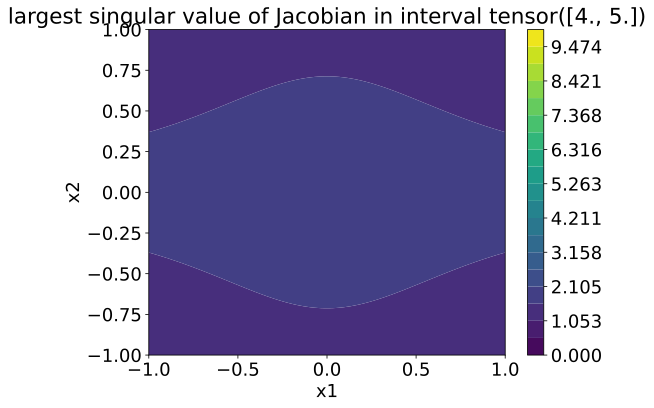

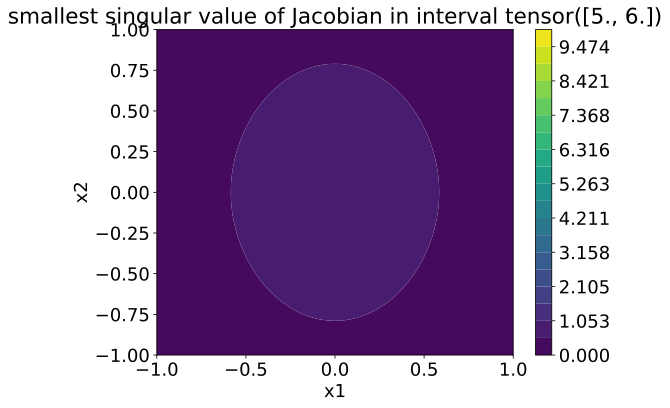

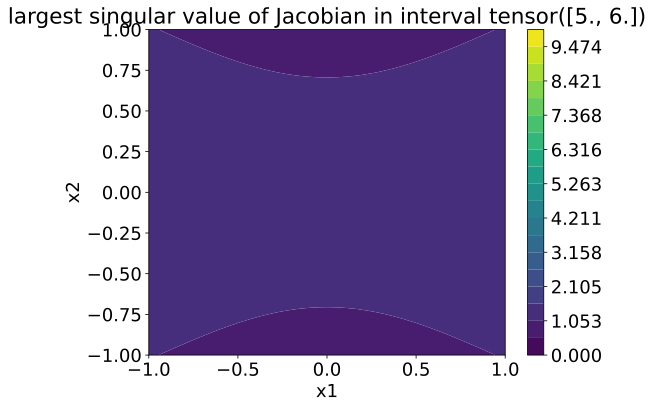

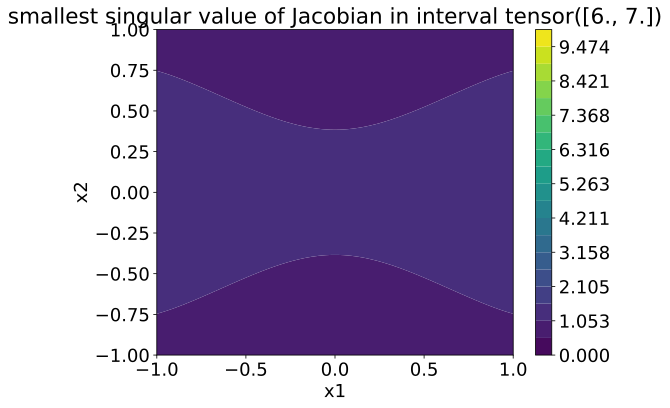

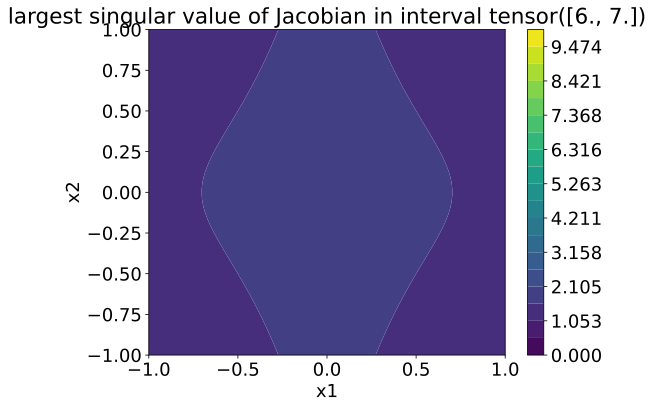

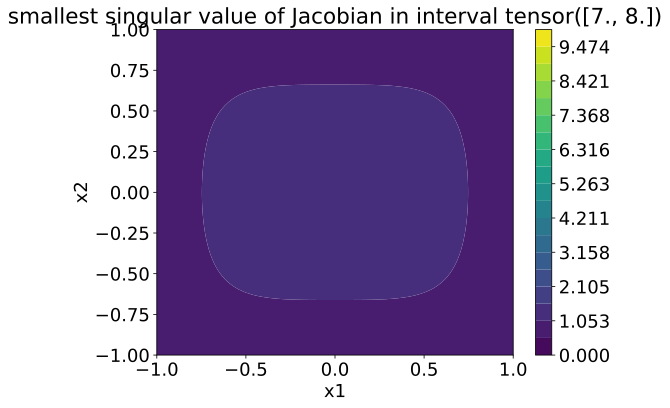

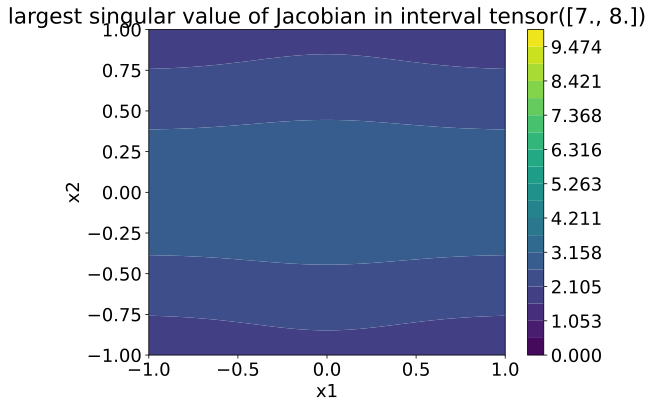

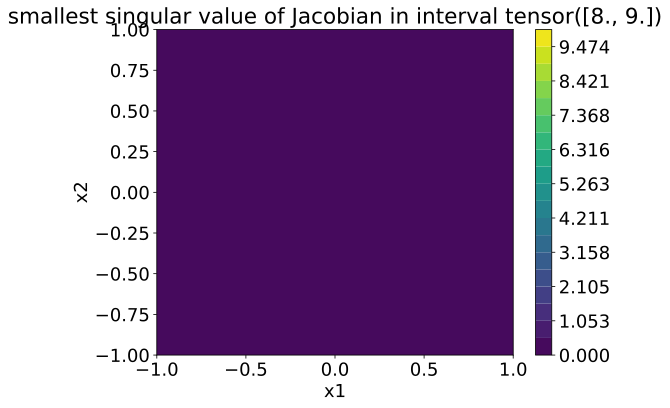

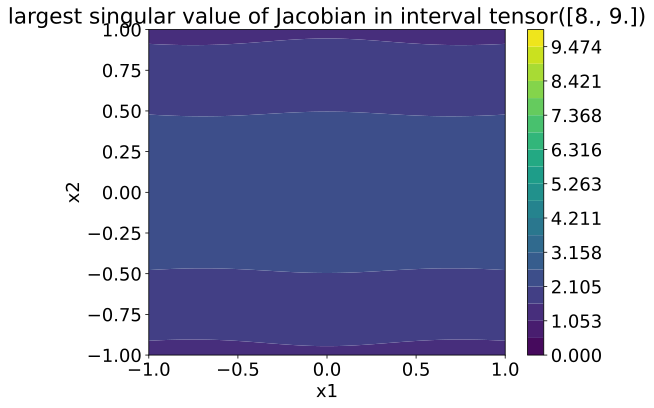

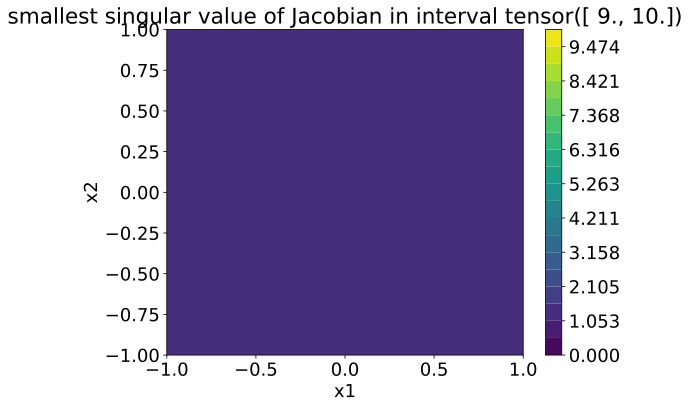

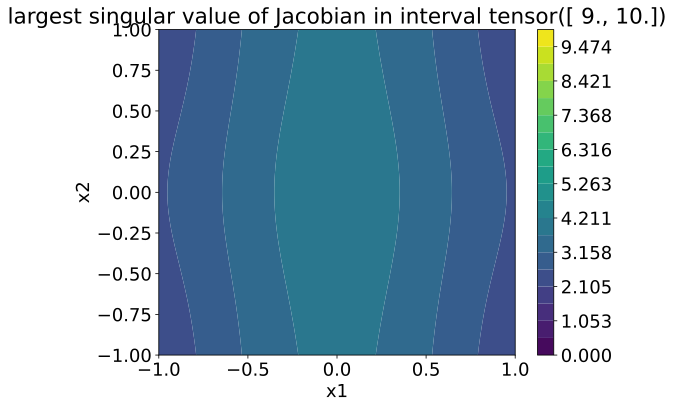

In [23]:
def psi_interval(x, model, time_interval = torch.tensor([0, T], dtype=torch.float32)):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^2.
    
    Returns:
      singular values of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = Jordan(x,model, time_interval = time_interval)
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1]
    
   
    return singular_values.detach().numpy()

# Define a grid over the input space.
grid_size = 100 # Adjust as needed.
x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)
psi_values = np.zeros((grid_size, grid_size, 2))

# Put the model in evaluation mode.
anode.eval()
# Define the number of levels for the contour plot
num_levels = 20
levels = np.linspace(0, 10, num_levels)

for layer in range(0,10):
  time_interval = torch.tensor([0,1], dtype=torch.float32) + layer

  # Evaluate psi(x) over the grid.
  for i, xv in enumerate(x_range):
      for j, yv in enumerate(y_range):
          # Create a 2D point as a torch tensor.
          x_point = torch.tensor([xv, yv], dtype=torch.float32)
          psi_values[j, i,:] = psi_interval(x_point, anode, time_interval = time_interval)

  # Plot the contour corresponding to psi ~ 0.

  # Here we plot the contour at a small level, e.g., 0.01.
  # CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')


  # Create the contour plot using the 'binary' colormap


  plt.figure(figsize=(8, 6))
  CS_min = plt.contourf(x_range, y_range, psi_values[:,:,1], levels=levels, cmap = 'viridis')
  cbar = plt.colorbar(CS_min)
  plt.title(f'smallest singular value of Jacobian in interval {time_interval}')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()
  
  plt.figure(figsize=(8, 6))
  CS_max = plt.contourf(x_range, y_range, psi_values[:,:,0], levels=levels, cmap = 'viridis')
  cbar = plt.colorbar(CS_max)
  plt.title(f'largest singular value of Jacobian in interval {time_interval}')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()


In [31]:
num_levels = 100
levels = np.linspace(0, 10, num_levels)

fig, axes = plt.subplots(2, num_params, figsize=(2 * num_params, 4), sharex=True, sharey=True)

# Ensure each plot is square with equal aspect ratio
for ax in axes.flatten():
    ax.set_aspect('equal')

for layer in range(num_params):
    time_interval = torch.tensor([0, 1], dtype=torch.float32) + layer
    
    # Evaluate psi(x) over the grid.
    for i, xv in enumerate(x_range):
      for j, yv in enumerate(y_range):
          # Create a 2D point as a torch tensor.
          x_point = torch.tensor([xv, yv], dtype=torch.float32)
          psi_values[j, i,:] = psi_interval(x_point, anode, time_interval = time_interval)

    # Plot the smallest singular value in the first row
    CS_min = axes[0, layer].contourf(x_range, y_range, psi_values[:, :, 1], levels=levels, cmap="viridis")
    axes[0, layer].set_title(f'Layer {layer}', fontsize=10)
    if layer == 0:
        axes[0, layer].set_ylabel('Min Singular Value')

    # Plot the largest singular value in the second row
    CS_max = axes[1, layer].contourf(x_range, y_range, psi_values[:, :, 0], levels=levels, cmap="viridis")
    if layer == 0:
        axes[1, layer].set_ylabel('Max Singular Value')

# Adjust layout to ensure square plots
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position the colorbar outside
fig.colorbar(CS_min, cax=cbar_ax)

plt.show()
